# Introduction


This work analyzes the historic data of KSM, DOT and BTC in order to decide on security parameters for the Kintsugi bridge. The code is general enough such that inspecting a new collateral asset can be done with minimal effort.

Historic price data is gathered from Coingecko, while order book data is collected from the Binance API. Binance is preferred over the other centralized exchanges because it has by far the largest trading volume (https://coinmarketcap.com/rankings/exchanges/).

There are two approaches that have been combined to arrive at a secure configuration, each applied conservatively. One applies and improves on the approach from the Gudgeon et al's DeFi Crisis paper (https://arxiv.org/pdf/2002.08099.pdf), which models price trajectories as stochastic processes. The other, Value at Risk (VaR), is a well-established method of quantifying financial losses. 

The parameters comprising the security configuration are: DEBT_CEILING_USD, LIQUIDATION_THRESHOLD, SECURE_THRESHOLD. The bridge also uses a PREMIUM_REDEEM_THRESHOLD to increase system security, but premium redeems are assumed not to occur in order to better capture tail risk. Of the three parameters, the first two are selected using the stochastic simulation while the last one is selected using VaR. Given the secure threshold has little bearing on the output of the simulation, its value is determined by VaR to have 99% confidence that a single-day devaluation of the collateral asset will not take vaults below the liquidation threshold.

Vaults are modelled as a single entity that mints the maximum wrapped amount on the first simulated day, at the secure threshold. This is a pessimistic assumption aimed at fully stress-testing the system.

One step of the simulation generates multiple price trajectories for both the collateral and the wrapped asset. Then, the worst trajectory of the collateral asset is picked. To match historic observation, a price trajectory for the wrapped asset is selected to produce a correlation as close to the real one as possible.

If, on any day, vaults fall below the liquidation ratio, their entire collateral is seized by the liquidation vault, causing the 1:1 peg to be destabilised. This is because vaults no longer have something to lose when stealing the BTC in their wallet. At this point, the "debt" in the system can only be liquidated by arbitrageurs who burn wrapped tokens in exchange for collateral at a beneficial rate. How beneficial this rate is is initially decided by the liquidation threshold, but if the backing asset keeps decreasing in value arbitrage profits can reach zero. In the event that the liquidation vault becomes undercollateralized, the relative value of the wrapped tokens to BTC would be equal to the collateralization rate.

Another conservative assumption is that liquidators mint their own wrapped tokens, thus requiring liquidity in both collateral and BTC. Although Gudgeon et al's paper assumes liquidity is equal to the daily traded volume, this works takes the more thorough approach of training a transaction cost (slippage) model. This is also in spite of simpler solutions being available, such as incorporating the bid-ask spread to obtain a liquidity-adjusted VaR. The larger the debt ceiling in the bridge, the more likely it is that liquidiators will move the market, and the liquidity-adjusted VaR would not have captured this insight. For invidividual KSM trades, which achieve small volumes compared to DOT, there is close to zero correlation between buy order amount (buyer-is-taker) and price movement. However, correlation appears when consecutive buy order are considered (with no sells in-between). After some manual filtering, the slippage model is trained on the most extreme of these data points.

In a similar work, Gauntlet (https://medium.com/gauntlet-networks/karura-parameter-recommendation-methodology-6ce7fe06cb77) also train a price impact model to measure how quickly the market recovers after large trades. The many pessimistic assumptions made in this analysis are considered to suffice and price is considered to stabilise by the next day, following the aforementioned trajectory. 

Among the improvements to be made in the future are the training of a price impact model and the aggregation of order book data from multiple exchanges. Moreover, the impact of buying wrapped tokens with collateral tokens on decentralized exchanges can also be modelled, and a custom loss function should be implemented for sci-kit learn, that prioritises exreme data points.

Finally, the selected security configuration for Kintsugi is:
```
DEBT_CEILING_USD = 20_000_000
LIQUIDATION_THRESHOLD = 2.0
SECURE_THRESHOLD = 2.5
```

TODO:
- model intraday collateral price plummeting vs slippage from liquidators

# Data reading and processing

In [1]:
# KSM/USD daily (queried 25 April 2022): https://api.coingecko.com/api/v3/coins/kusama/market_chart?vs_currency=usd&days=114
# KINT/USD daily (queried 25 April 2022): https://api.coingecko.com/api/v3/coins/kintsugi/market_chart?vs_currency=usd&days=114
# DOT/USD daily (queried 25 April 2022): https://api.coingecko.com/api/v3/coins/polkadot/market_chart?vs_currency=usd&days=114
# BTC/USD daily (queried 25 April 2022): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=114
# `./download_trades` script made to download Binance data

In [2]:
%load_ext nb_black

import json
from scipy.stats import pearsonr
import math
import datetime

from sklearn import linear_model
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pandas as pd


def get_usd_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    return [price for (timestamp, price) in data["prices"]]


def get_volume_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = []
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes.append(usd_volume / prices[i])
    return volumes


def get_daily_volumes_dict(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = dict()
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes[timestamp] = usd_volume
    return volumes


def determine_price_between_assets(asset_1_prices, asset_2_prices):
    return [
        asset_1_price / asset_2_price
        for (asset_1_price, asset_2_price) in zip(asset_1_prices, asset_2_prices)
    ]


def prices_to_returns(prices):
    return [(prices[i] / prices[i - 1] - 1) for i in range(1, len(prices))]


def round_timestamp_to_nearest_gmt_date(unix_timestamp):
    import os

    date_format = "%d/%m/%Y"
    os.environ["TZ"] = "GMT"
    parsed_date = datetime.datetime.fromtimestamp(
        int(unix_timestamp) / 1000.0
    ).strftime(date_format)
    return (
        int(datetime.datetime.strptime(parsed_date, date_format).timestamp() + 3600)
        * 1000
    )


def read_trading_data(file):
    # Assumes Binance format
    # https://github.com/binance/binance-public-data/#trades
    names = [
        "trade_id",
        "price",
        "qty",
        "quote_qty",
        "time",
        "is_buyer_maker",
        "is_best_match",
    ]
    df = pd.read_csv(file, names=names)
    return df.drop(columns=["trade_id", "quote_qty", "is_best_match"])


def clean_trading_data_consecutively(
    trading_data, daily_volumes_dict, max_item_count, min_total_qty, min_price_change
):
    # simplify df to be ready for regression
    cleaned_df = pd.DataFrame(columns=["qty", "caused_price_change"])
    cleaned_df_index = 0
    prev_price = 1
    prev_qty = 0
    prev_nearest_date = 0
    prev_qty_to_volume_ratio = 0
    prev_is_buyer_maker = False
    i = -1
    while i < len(trading_data.index):
        i += 1
        row = trading_data.iloc[i]
        if row["is_buyer_maker"] == True:
            continue
        initial_price = row["price"]
        j = i
        total_qty = 0
        while row["is_buyer_maker"] == False and j < len(trading_data.index):
            row = trading_data.iloc[j]
            total_qty += row["qty"]
            j += 1
        price_change = (row["price"] / initial_price) - 1
        if i == j or total_qty < min_total_qty or price_change < min_price_change:
            continue
        cleaned_df.loc[cleaned_df_index] = [
            total_qty,
            price_change,
        ]
        cleaned_df_index += 1
        print("Added elements: " + str(cleaned_df_index))
        i = j
        if cleaned_df_index > max_item_count:
            break
    return cleaned_df

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [1]:
%load_ext nb_black

import json
from scipy.stats import pearsonr
import math
import datetime

from sklearn import linear_model
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import numpy as np
import statistics
import pandas as pd


def get_usd_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    return [price for (timestamp, price) in data["prices"]]


def get_volume_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = []
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes.append(usd_volume / prices[i])
    return volumes


def get_daily_volumes_dict(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = dict()
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes[timestamp] = usd_volume
    return volumes


def determine_price_between_assets(asset_1_prices, asset_2_prices):
    return [
        asset_1_price / asset_2_price
        for (asset_1_price, asset_2_price) in zip(asset_1_prices, asset_2_prices)
    ]


def prices_to_returns(prices):
    return [(prices[i] / prices[i - 1] - 1) for i in range(1, len(prices))]


def round_timestamp_to_nearest_gmt_date(unix_timestamp):
    import os

    date_format = "%d/%m/%Y"
    os.environ["TZ"] = "GMT"
    parsed_date = datetime.datetime.fromtimestamp(
        int(unix_timestamp) / 1000.0
    ).strftime(date_format)
    return (
        int(datetime.datetime.strptime(parsed_date, date_format).timestamp() + 3600)
        * 1000
    )


def read_trading_data(file):
    # Assumes Binance format
    # https://github.com/binance/binance-public-data/#trades
    names = [
        "trade_id",
        "price",
        "qty",
        "quote_qty",
        "time",
        "is_buyer_maker",
        "is_best_match",
    ]
    df = pd.read_csv(file, names=names)
    return df.drop(columns=["trade_id", "quote_qty", "is_best_match"])


def clean_trading_data_consecutively(
    trading_data, daily_volumes_dict, max_item_count, min_total_qty, min_price_change
):
    # simplify df to be ready for regression
    cleaned_df = pd.DataFrame(columns=["qty", "caused_price_change"])
    cleaned_df_index = 0
    prev_price = 1
    prev_qty = 0
    prev_nearest_date = 0
    prev_qty_to_volume_ratio = 0
    prev_is_buyer_maker = False
    i = -1
    while i < len(trading_data.index):
        i += 1
        row = trading_data.iloc[i]
        if row["is_buyer_maker"] == True:
            continue
        initial_price = row["price"]
        j = i
        total_qty = 0
        while row["is_buyer_maker"] == False and j < len(trading_data.index):
            row = trading_data.iloc[j]
            total_qty += row["qty"]
            j += 1
        price_change = (row["price"] / initial_price) - 1
        if i == j or total_qty < min_total_qty or price_change < min_price_change:
            continue
        cleaned_df.loc[cleaned_df_index] = [
            total_qty,
            price_change,
        ]
        cleaned_df_index += 1
        print("Added elements: " + str(cleaned_df_index))
        i = j
        if cleaned_df_index > max_item_count:
            break
    return cleaned_df


ksm_to_usd_daily = get_usd_timeseries("kusama_to_usd_daily_2021.json")
ksm_usd_returns_daily = prices_to_returns(ksm_to_usd_daily)

dot_to_usd_daily = get_usd_timeseries("polkadot_to_usd_daily_2021.json")
dot_usd_returns_daily = prices_to_returns(dot_to_usd_daily)

btc_to_usd_daily = get_usd_timeseries("bitcoin_to_usd_daily_2021.json")
btc_usd_returns_daily = prices_to_returns(btc_to_usd_daily)

ksm_to_btc_daily = determine_price_between_assets(ksm_to_usd_daily, btc_to_usd_daily)
ksm_to_btc_returns_daily = prices_to_returns(ksm_to_btc_daily)
observed_ksm_btc_corr, _ = pearsonr(ksm_usd_returns_daily, btc_usd_returns_daily)


dot_to_btc_daily = determine_price_between_assets(dot_to_usd_daily, btc_to_usd_daily)
dot_to_btc_returns_daily = prices_to_returns(dot_to_btc_daily)
observed_dot_btc_corr, _ = pearsonr(dot_usd_returns_daily, btc_usd_returns_daily)

ksm_daily_volumes = get_volume_timeseries("kusama_to_usd_daily_2021.json")
ksm_volumes_dict = get_daily_volumes_dict("kusama_to_usd_daily_2021.json")

dot_daily_volumes = get_volume_timeseries("polkadot_to_usd_daily_2021.json")
dot_volumes_dict = get_daily_volumes_dict("polkadot_to_usd_daily_2021.json")

btc_daily_volumes = get_volume_timeseries("bitcoin_to_usd_daily_2021.json")
btc_volumes_dict = get_daily_volumes_dict("bitcoin_to_usd_daily_2021.json")

print("KSM/BTC correlation is: " + str(observed_ksm_btc_corr))
print("DOT/BTC correlation is: " + str(observed_dot_btc_corr))

FileNotFoundError: [Errno 2] No such file or directory: 'kusama_to_usd_daily_2021.json'

<IPython.core.display.Javascript object>

In [3]:
# Read BTC price history
btc_to_usd_daily = get_usd_timeseries("price_data/btc_25_april_2022.json")
btc_usd_returns_daily = prices_to_returns(btc_to_usd_daily)

# Read KINT price history
kint_to_usd_daily = get_usd_timeseries("price_data/kint_25_april_2022.json")
kint_usd_returns_daily = prices_to_returns(kint_to_usd_daily)

kint_to_btc_daily = determine_price_between_assets(kint_to_usd_daily, btc_to_usd_daily)
kint_to_btc_returns_daily = prices_to_returns(kint_to_btc_daily)
observed_kint_btc_corr, _ = pearsonr(kint_usd_returns_daily, btc_usd_returns_daily)

# Read USDC price history
usdc_to_usd_daily = get_usd_timeseries("price_data/usdc_25_april_2022.json")
usdc_usd_returns_daily = prices_to_returns(usdc_to_usd_daily)

usdc_to_btc_daily = determine_price_between_assets(usdc_to_usd_daily, btc_to_usd_daily)
usdc_to_btc_returns_daily = prices_to_returns(usdc_to_btc_daily)
observed_usdc_btc_corr, _ = pearsonr(usdc_usd_returns_daily, btc_usd_returns_daily)

# Read KSM price history
ksm_to_usd_daily = get_usd_timeseries("price_data/ksm_25_april_2022.json")
ksm_usd_returns_daily = prices_to_returns(ksm_to_usd_daily)

ksm_to_btc_daily = determine_price_between_assets(ksm_to_usd_daily, btc_to_usd_daily)
ksm_to_btc_returns_daily = prices_to_returns(ksm_to_btc_daily)
observed_ksm_btc_corr, _ = pearsonr(ksm_usd_returns_daily, btc_usd_returns_daily)

# Read DOT price history
dot_to_usd_daily = get_usd_timeseries("price_data/dot_25_april_2022.json")
dot_usd_returns_daily = prices_to_returns(dot_to_usd_daily)

dot_to_btc_daily = determine_price_between_assets(dot_to_usd_daily, btc_to_usd_daily)
dot_to_btc_returns_daily = prices_to_returns(dot_to_btc_daily)
observed_dot_btc_corr, _ = pearsonr(dot_usd_returns_daily, btc_usd_returns_daily)

# Read trading volumes for the liquidity model
ksm_daily_volumes = get_volume_timeseries("kusama_to_usd_daily_2021.json")
ksm_volumes_dict = get_daily_volumes_dict("kusama_to_usd_daily_2021.json")

dot_daily_volumes = get_volume_timeseries("polkadot_to_usd_daily_2021.json")
dot_volumes_dict = get_daily_volumes_dict("polkadot_to_usd_daily_2021.json")

btc_daily_volumes = get_volume_timeseries("bitcoin_to_usd_daily_2021.json")
btc_volumes_dict = get_daily_volumes_dict("bitcoin_to_usd_daily_2021.json")

print("KINT/BTC correlation is: " + str(observed_kint_btc_corr))
print("USDC/BTC correlation is: " + str(observed_usdc_btc_corr))
print("KSM/BTC correlation is: " + str(observed_ksm_btc_corr))
print("DOT/BTC correlation is: " + str(observed_dot_btc_corr))


<IPython.core.display.Javascript object>

In [5]:
btc_raw_trading_data = read_trading_data("BTC_trades.csv")

<IPython.core.display.Javascript object>

In [15]:
# Filter data to only keep extreme cases, to train a conservative slippage model
btc_trading_data = clean_trading_data_consecutively(
    btc_raw_trading_data, btc_volumes_dict, 20, 5, 0.000001
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21


<IPython.core.display.Javascript object>

In [12]:
ksm_raw_trading_data = read_trading_data("KSM_trades.csv")

<IPython.core.display.Javascript object>

In [13]:
# Filter data to only keep extreme cases, to train a conservative slippage model
ksm_trading_data = clean_trading_data_consecutively(
    ksm_raw_trading_data, ksm_volumes_dict, 10, 10, 0.006
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11


<IPython.core.display.Javascript object>

In [7]:
dot_raw_trading_data = read_trading_data("DOT_trades.csv")

<IPython.core.display.Javascript object>

In [10]:
# Filter data to only keep extreme case, to train a conservative slippage model
dot_trading_data = clean_trading_data_consecutively(
    dot_raw_trading_data, dot_volumes_dict, 50, 200, 0.0005
)

Added elements: 1
Added elements: 2
Added elements: 3
Added elements: 4
Added elements: 5
Added elements: 6
Added elements: 7
Added elements: 8
Added elements: 9
Added elements: 10
Added elements: 11
Added elements: 12
Added elements: 13
Added elements: 14
Added elements: 15
Added elements: 16
Added elements: 17
Added elements: 18
Added elements: 19
Added elements: 20
Added elements: 21
Added elements: 22
Added elements: 23
Added elements: 24
Added elements: 25
Added elements: 26
Added elements: 27
Added elements: 28
Added elements: 29
Added elements: 30
Added elements: 31
Added elements: 32
Added elements: 33
Added elements: 34
Added elements: 35
Added elements: 36
Added elements: 37
Added elements: 38
Added elements: 39
Added elements: 40
Added elements: 41
Added elements: 42
Added elements: 43
Added elements: 44
Added elements: 45
Added elements: 46
Added elements: 47
Added elements: 48
Added elements: 49
Added elements: 50
Added elements: 51


<IPython.core.display.Javascript object>

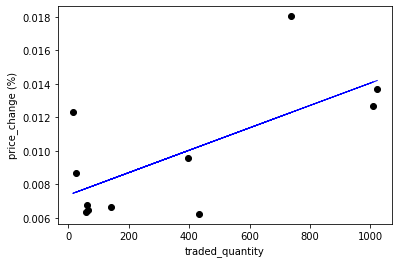

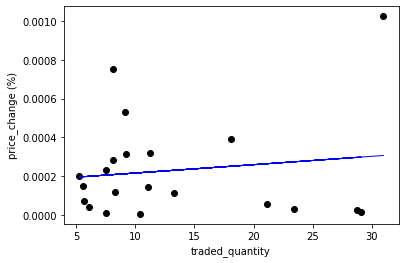

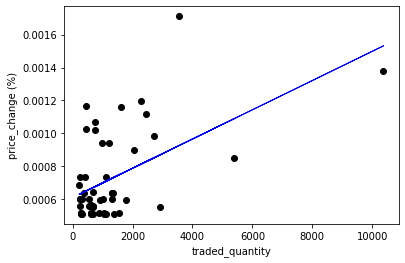

<IPython.core.display.Javascript object>

In [16]:
def get_regression_model(trading_data, min_price_change=None, max_qty=None):
    filtered_data = trading_data
    if min_price_change and max_qty:
        filtered_data = filtered_data[
            (filtered_data["caused_price_change"] > 0.01) & (filtered_data["qty"] < 400)
        ]
    x = filtered_data.qty.values
    y = filtered_data.caused_price_change.values

    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)

    regr = linear_model.LinearRegression()
    result = regr.fit(x, y)
    model = result.predict
    plt.scatter(x, y, color="black")
    plt.plot(x, model(x), color="blue", linewidth=1)
    plt.ylabel("price_change (%)")
    plt.xlabel("traded_quantity")
    plt.show()
    return model


ksm_liquidity_model = get_regression_model(ksm_trading_data)
btc_liquidity_model = get_regression_model(btc_trading_data)
dot_liquidity_model = get_regression_model(dot_trading_data)

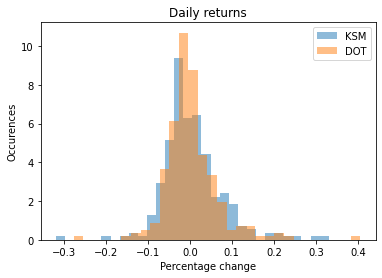

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [358]:
def plot_returns(returns, data_label, title):
    plt.hist(returns, density=True, bins=30, alpha=0.5, label=data_label)
    plt.ylabel("Occurences")
    plt.xlabel("Percentage change")
    plt.legend(loc="upper right")
    plt.title(title)


plot_returns(ksm_to_btc_returns_daily, "KSM", "Daily returns")
plot_returns(dot_to_btc_returns_daily, "DOT", "Daily returns")

# Monte Carlo Simulation
https://arxiv.org/pdf/2002.08099.pdf

Independently simulates the prices of collateral and BTC.

Selects the worst collateral/USD price trajectory, then picks the BTC/USD price trajectory that has the closest pearson correlation to the one in the real data sample.

All vaults are considered a single entity, but they are separated from the liquidation vault. When vaults become undercollateralized, liquidators acquire as much liquidity as possible to arbitrage, taking slippage into account. Liquidators are assumed ot start up their own vault before liquidating, so both collateral and Bitcoin liquidity need to be modelled.

Even if slippage is considered, it is assumed that prices recover by the next day. While this is an optimistic assumption, the conservative slippage model balances it out.

In [56]:
# Should simulate more scenarios
SIMULATED_SCENARIOS = 500
PRICE_PATHS_PER_SIMULATION = 500
PREDICTED_DAYS = 100

# premium redeem is skipped
PREMIUM_REDEEM_BONUS = 0.05

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Monte Carlo price simulation (Geometric Brownian Motion)
# Reference article: https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18


def stochastic_price_simulation(
    returns, initial_price, prediction_days, scenario_count
):
    So = initial_price
    dt = 1
    T = prediction_days
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(returns)
    sigma = np.std(returns)
    scen_size = scenario_count
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    # Calculating drift and diffusion components
    drift = (mu - 0.5 * sigma ** 2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    # Making the predictions
    S = np.array(
        [So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]
    )
    S = np.hstack(
        (np.array([[So] for scen in range(scen_size)]), S)
    )  # add So to the beginning series

    # Plotting the simulations
    #     plt.figure(figsize = (20,10))
    #     for i in range(scen_size):
    #         plt.title("Daily Volatility: " + str(sigma))
    #         plt.plot(S[i, :])
    #         plt.ylabel('Price')
    #         plt.xlabel('Prediction Days')
    #     plt.show()
    return S


def get_worst_price_trajectory(S):
    min_price = S[0, -1]
    index = 0
    for i in range(len(S)):
        if S[i, -1] < min_price:
            min_price = S[i, -1]
            index = i
    return S[index, :]


def get_trajectory_with_closest_correlation(S, base_trajectory, corr):
    picked_trajectory = S[0, :]
    index = 0
    closest_found_correlation, _ = pearsonr(base_trajectory, S[0, :])
    for i in range(len(S)):
        tmp_corr, _ = pearsonr(base_trajectory, S[i, :])
        if abs(tmp_corr - corr) < abs(closest_found_correlation - corr):
            closest_found_correlation = tmp_corr
            picked_trajectory = S[i, :]
            index = i
    return S[index, :], closest_found_correlation


def find_profitable_volume(
    secure_threshold,
    collateral_usd,
    btc_usd,
    collateral_liquidity_model,
    btc_liquidity_model,
    liquidation_vault_issued,
    liquidation_vault_collateral,
):
    burn_exchange_rate = (
        (liquidation_vault_collateral * collateral_usd)
        / (liquidation_vault_issued * btc_usd)
        * (collateral_usd / btc_usd)
    )
    btc_amount = liquidation_vault_issued
    while btc_amount > 0:
        collateral_amount = btc_amount * btc_usd / collateral_usd * secure_threshold
        btc_price_change = btc_liquidity_model([[btc_amount]])[0][0]
        collateral_price_change = collateral_liquidity_model([[collateral_amount]])[0][
            0
        ]
        new_btc_price = btc_usd * (1 + btc_price_change)
        new_collateral_price = collateral_usd * (1 + collateral_price_change)
        # assume that if new exchange rate is equal to the burn rate,
        # we stop buying
        new_exchange_rate = new_collateral_price / new_btc_price
        if burn_exchange_rate >= new_exchange_rate:
            return btc_amount
        btc_amount -= 5
    return 0


def get_days_of_undercollateralization(
    worst_collateral_scenario_trajectory,
    correlated_btc_scenario_trajectory,
    collateral_liquidity_model,
    btc_liquidity_model,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
):
    starting_collateral_price = worst_collateral_scenario_trajectory[0]
    starting_btc_price = correlated_btc_scenario_trajectory[0]
    vaults_issued = (debt_ceiling_usd / secure_threshold) / starting_btc_price
    vaults_collateral = debt_ceiling_usd / starting_collateral_price

    liquidation_vault_issued = 0
    liquidation_vault_collateral = 0
    current_collateral_to_btc_price = starting_collateral_price / starting_btc_price

    system_collateral_daily = []
    vault_collateral_daily = []
    liquidation_vault_btc_daily = []
    daily_collateralization = []
    days_of_undercollateralization = 0
    for (collateral_usd, btc_usd) in zip(
        worst_collateral_scenario_trajectory, correlated_btc_scenario_trajectory
    ):
        current_collateral_to_btc_price = collateral_usd / btc_usd
        vault_required_collateral = vaults_issued / current_collateral_to_btc_price
        system_required_collateral = (
            vaults_issued + liquidation_vault_issued
        ) / current_collateral_to_btc_price
        system_collateral_daily.append(system_required_collateral)
        vault_collateral_daily.append(vaults_collateral)
        liquidation_vault_btc_daily.append(liquidation_vault_issued)
        system_collateralization = (
            vaults_collateral + liquidation_vault_collateral
        ) / system_required_collateral
        if (
            vaults_issued > 0
            and vaults_collateral / vault_required_collateral < liquidation_threshold
        ):
            # liquidate every vault
            liquidation_vault_issued = vaults_issued
            vaults_issued = 0
            liquidation_vault_collateral = vaults_collateral
            vaults_collateral = 0
        if liquidation_vault_issued > 0:
            btc_arbitrage_amount = find_profitable_volume(
                secure_threshold,
                collateral_usd,
                btc_usd,
                collateral_liquidity_model,
                btc_liquidity_model,
                liquidation_vault_issued,
                liquidation_vault_collateral,
            )

            # mint interbtc for the liquidation
            newly_added_collateral = (
                btc_arbitrage_amount / current_collateral_to_btc_price
            ) * secure_threshold
            vaults_issued += btc_arbitrage_amount
            vaults_collateral += newly_added_collateral

            # perform burn redeem
            burn_exchange_rate = (
                (liquidation_vault_collateral * collateral_usd)
                / (liquidation_vault_issued * btc_usd)
                * current_collateral_to_btc_price
            )
            burn_dot_payout = btc_arbitrage_amount / burn_exchange_rate
            liquidation_vault_issued -= btc_arbitrage_amount
            liquidation_vault_collateral = round(
                liquidation_vault_collateral - burn_dot_payout
            )
        daily_collateralization.append(system_collateralization)
        if system_collateralization < 1:
            days_of_undercollateralization += 1
    return (
        days_of_undercollateralization,
        daily_collateralization,
        liquidation_vault_btc_daily,
    )


def get_worst_pair_of_price_trajectories(
    scenarios_count,
    asset_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    collateral_usd_returns_daily,
    collateral_to_usd_daily,
    collateral_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
):
    worst_btc_trajectory = []
    worst_collateral_trajectory = []
    most_days_of_undercollateralization = 0
    worst_daily_collateralization_trajectory = []
    worst_liquidation_vault_collateral_trajectory = []
    for i in range(scenarios_count):
        collateral_price_simulations = stochastic_price_simulation(
            collateral_usd_returns_daily,
            collateral_to_usd_daily[-1],
            PREDICTED_DAYS,
            PRICE_PATHS_PER_SIMULATION,
        )
        worst_collateral_scenario_trajectory = get_worst_price_trajectory(
            collateral_price_simulations
        )
        btc_price_simulations = stochastic_price_simulation(
            btc_usd_returns_daily,
            btc_to_usd_daily[-1],
            PREDICTED_DAYS,
            PRICE_PATHS_PER_SIMULATION,
        )
        (
            correlated_btc_scenario_trajectory,
            closest_found_correlation,
        ) = get_trajectory_with_closest_correlation(
            btc_price_simulations, worst_collateral_scenario_trajectory, asset_corr
        )
        (
            days_of_undercollateralization,
            daily_collateralization,
            liquidation_vault_btc_daily,
        ) = get_days_of_undercollateralization(
            worst_collateral_scenario_trajectory,
            correlated_btc_scenario_trajectory,
            collateral_liquidity_model,
            btc_liquidity_model,
            debt_ceiling_usd,
            secure_threshold,
            liquidation_threshold,
        )
        if (
            days_of_undercollateralization > most_days_of_undercollateralization
            or most_days_of_undercollateralization == 0
        ):
            most_days_of_undercollateralization = days_of_undercollateralization
            worst_btc_trajectory = correlated_btc_scenario_trajectory
            worst_collateral_trajectory = worst_collateral_scenario_trajectory
            worst_daily_collateralization_trajectory = daily_collateralization
            worst_liquidation_vault_collateral_trajectory = liquidation_vault_btc_daily
    return (
        worst_collateral_trajectory,
        worst_btc_trajectory,
        worst_daily_collateralization_trajectory,
        worst_liquidation_vault_collateral_trajectory,
        most_days_of_undercollateralization,
    )

<IPython.core.display.Javascript object>

In [19]:
%reload_ext nb_black


def plot_collateralization(
    subplot,
    liquidation_vault_issued_daily,
    daily_collateralization,
    liquidation_threshold,
):
    subplot.plot([l / 1000 for l in liquidation_vault_issued_daily])
    subplot.plot(daily_collateralization)
    subplot.plot([liquidation_threshold] * len(daily_collateralization))
    subplot.plot([1.0] * len(daily_collateralization))
    subplot.legend(
        [
            "liquidation_vault_issued (thousands)",
            "collateralization",
            "liquidation threshold",
            "undercollateralization",
        ]
    )


def plot_prices(subplot, collateral_price_trajectory, btc_price_trajectory):
    subplot.plot([price * 1000 for price in collateral_price_trajectory])
    subplot.plot(btc_price_trajectory)
    subplot.legend(["collateral price (x0.001)", "btc price"])


def simulate_and_plot(
    simulated_scenarios,
    observed_collateral_to_btc_corr,
    debt_ceiling_usd,
    secure_threshold,
    liquidation_threshold,
    collateral_usd_returns_daily,
    collateral_to_usd_daily,
    collateral_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
):
    (
        collateral_price_trajectory,
        btc_price_trajectory,
        daily_collateralization,
        liquidation_vault_issued_daily,
        days_of_undercollateralization,
    ) = get_worst_pair_of_price_trajectories(
        simulated_scenarios,
        observed_collateral_to_btc_corr,
        debt_ceiling_usd,
        secure_threshold,
        liquidation_threshold,
        collateral_usd_returns_daily,
        collateral_to_usd_daily,
        collateral_liquidity_model,
        btc_usd_returns_daily,
        btc_to_usd_daily,
        btc_liquidity_model,
    )

    print("days of undercollateralization: " + str(days_of_undercollateralization))
    fig, axs = plt.subplots(2, figsize=(12, 10))
    plot_collateralization(
        axs[0],
        liquidation_vault_issued_daily,
        daily_collateralization,
        liquidation_threshold,
    )
    plot_prices(axs[1], collateral_price_trajectory, btc_price_trajectory)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

days of undercollateralization: 25


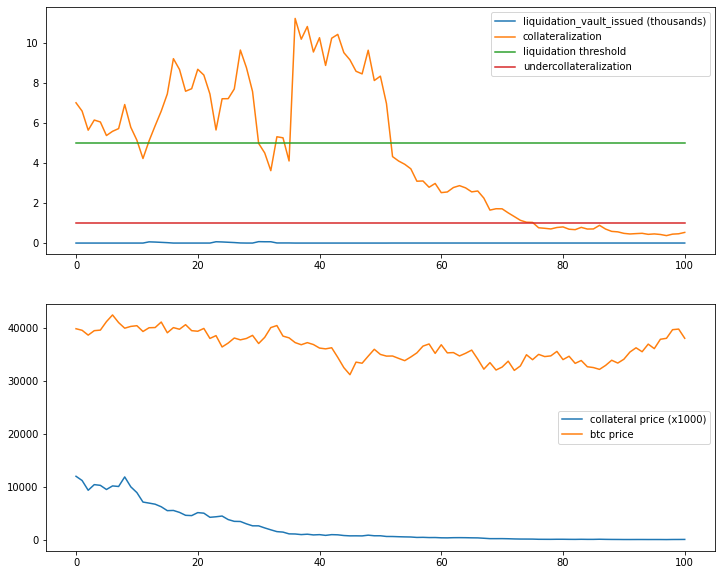

In [64]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.0
LIQUIDATION_THRESHOLD = 1.5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    dot_usd_returns_daily,
    dot_to_usd_daily,
    dot_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

In [48]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 7
LIQUIDATION_THRESHOLD = 5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    kint_usd_returns_daily,
    kint_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

trajectory points:
2401
days of undercollateralization: 1


<Figure size 864x720 with 2 Axes>

<IPython.core.display.Javascript object>

days of undercollateralization: 5


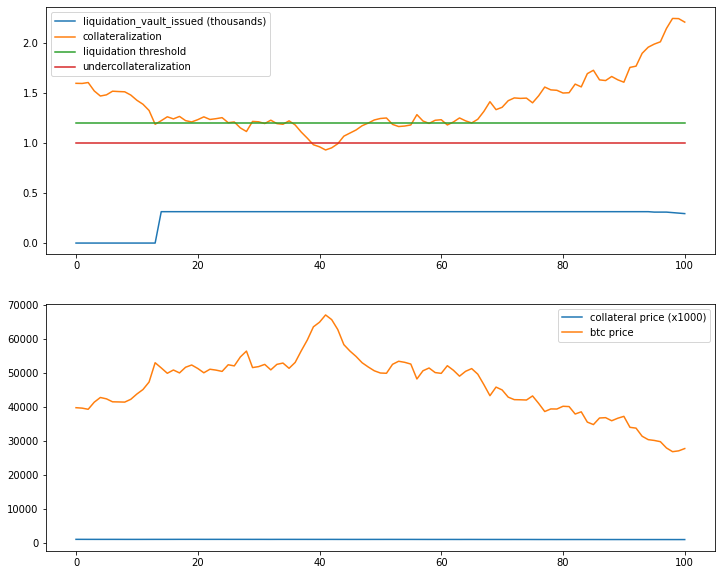

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 1.6
LIQUIDATION_THRESHOLD = 1.2
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    usdc_usd_returns_daily,
    usdc_to_usd_daily,
    btc_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    ksm_liquidity_model,
)

days of undercollateralization: 5


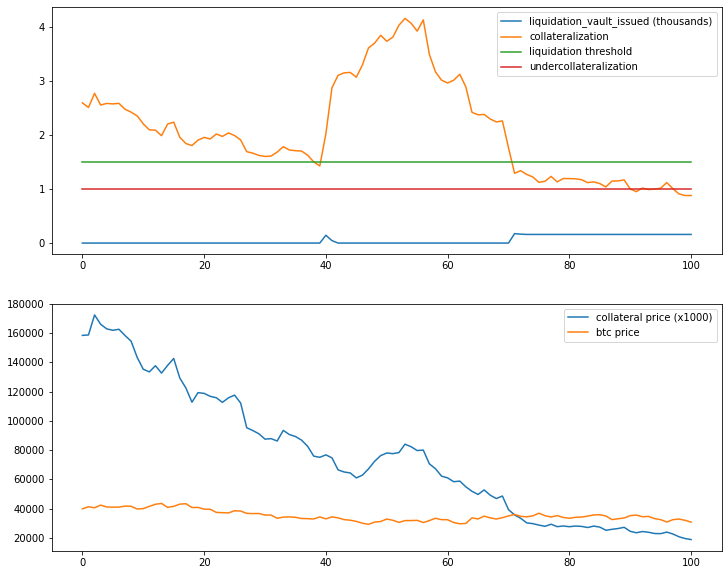

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.6
LIQUIDATION_THRESHOLD = 1.5
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    ksm_usd_returns_daily,
    ksm_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

In [57]:
DEBT_CEILING_USD = 20_000_000
SECURE_THRESHOLD = 2.8
LIQUIDATION_THRESHOLD = 2.2
simulate_and_plot(
    SIMULATED_SCENARIOS,
    observed_ksm_btc_corr,
    DEBT_CEILING_USD,
    SECURE_THRESHOLD,
    LIQUIDATION_THRESHOLD,
    ksm_usd_returns_daily,
    ksm_to_usd_daily,
    ksm_liquidity_model,
    btc_usd_returns_daily,
    btc_to_usd_daily,
    btc_liquidity_model,
)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Value At Risk (VAR) Model
https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote7.pdf

In [58]:
def get_var(bid_ask_spread, threshold, daily_returns):
    confidence_99_9 = 3.29
    confidence_99 = 2.57
    confidence_95 = 1.96
    # Compute stddev using the daily returns, as these have higher volatility
    # VaR occasionally underestimates the number of large market moves.
    # Could consider a higher confidence interval to be on the safe side
    std_dev = statistics.pstdev(daily_returns)
    expected_loss_percentage_99_9 = confidence_99_9 * std_dev * (bid_ask_spread / 2 + 1)
    expected_loss_percentage_99 = confidence_99 * std_dev * (bid_ask_spread / 2 + 1)
    expected_loss_percentage_95 = confidence_95 * std_dev * (bid_ask_spread / 2 + 1)
    print(
        "99.9% confidence interval max price drop (%): "
        + str(expected_loss_percentage_99_9 * 100)
    )
    required_collateralization_99_9 = threshold / (1 - expected_loss_percentage_99_9)
    required_collateralization_99 = threshold / (1 - expected_loss_percentage_99)
    required_collateralization_95 = threshold / (1 - expected_loss_percentage_95)
    print("Liquidation threshold assumption: " + str(threshold))
    print(
        "Required collateralization (99.9% confidence interval): "
        + str(required_collateralization_99_9)
    )
    print(
        "Required collateralization (99% confidence interval): "
        + str(required_collateralization_99)
    )
    print(
        "Required collateralization (95% confidence interval): "
        + str(required_collateralization_95)
    )


DOT_BTC_bid_ask_spread = 0.001
DOT_PREMIUM_REDEEM_THRESHOLD = 2.6
print("DOT VaR results")
get_var(DOT_BTC_bid_ask_spread, DOT_PREMIUM_REDEEM_THRESHOLD, dot_to_btc_returns_daily)
print()
print("KSM VaR results")
KSM_BTC_bid_ask_spread = 0.003
KSM_PREMIUM_REDEEM_THRESHOLD = 2.8
get_var(KSM_BTC_bid_ask_spread, KSM_PREMIUM_REDEEM_THRESHOLD, ksm_to_btc_returns_daily)

DOT VaR results
99.9% confidence interval max price drop (%): 19.542940371123173
Liquidation threshold assumption: 2.6
Required collateralization (99.9% confidence interval): 3.2315374337478704
Required collateralization (99% confidence interval): 3.0684282832872705
Required collateralization (95% confidence interval): 2.942594600606168

KSM VaR results
99.9% confidence interval max price drop (%): 22.06529964569
Liquidation threshold assumption: 2.8
Required collateralization (99.9% confidence interval): 3.592751351157472
Required collateralization (99% confidence interval): 3.3831305779788847
Required collateralization (95% confidence interval): 3.2237743185558307


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# Selected parameters DOT
# DEBT_CEILING_USD = 20_000_000

SECURE_THRESHOLD = 3.3
PREMIUM_REDEEM_THRESHOLD = 2.6
LIQUIDATION_THRESHOLD = 2.0

# Selected parameters KSM
# DEBT_CEILING_USD = 20_000_000

SECURE_THRESHOLD = 3.6
PREMIUM_REDEEM_THRESHOLD = 2.8
LIQUIDATION_THRESHOLD = 2.2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>